In [3]:
%matplotlib inline


Moving from CTC to RNN Transducer Loss with torchaudio
------------------------------------------------------

This tutorial will discuss how to work with CTC and the RNN Transducer loss in torchaudio.

Colab has GPU option available. In the menu tabs, select “Runtime” then
“Change runtime type”. In the pop-up that follows, you can choose GPU.
After the change, your runtime should automatically restart (which means
information from executed cells disappear).

First, let’s import the common torch packages such as
`torchaudio <https://github.com/pytorch/audio>`__ that can be installed
by following the instructions on the website.




In [4]:
!pip install --pre torch==1.9.0.dev20210416+cpu torchaudio==0.9.0.dev20210416 -f https://download.pytorch.org/whl/nightly/cpu/torch_nightly.html

Looking in links: https://download.pytorch.org/whl/nightly/cpu/torch_nightly.html
     |████████████████████████████████| 178.1MB 55kB/s 
     |████████████████████████████████| 1.9MB 55.8MB/s 
ERROR: torchvision 0.9.1+cu101 has requirement torch==1.8.1, but you'll have torch 1.9.0.dev20210416+cpu which is incompatible.
ERROR: torchtext 0.9.1 has requirement torch==1.8.1, but you'll have torch 1.9.0.dev20210416+cpu which is incompatible.
  Found existing installation: torch 1.8.1+cu101
    Uninstalling torch-1.8.1+cu101:
      Successfully uninstalled torch-1.8.1+cu101


In [5]:
"""
!pip install torch==1.7.0+cu101 -f https://download.pytorch.org/whl/torch_stable.html

# Reload packages available in google colab
import site
site.main()

# Compile from source
!rm -rf audio/
!git clone --recurse-submodules --single-branch https://github.com/pytorch/audio.git
!BUILD_TRANSDUCER=1 BUILD_SOX=1 pip install -v audio/

site.main()
""";

In [6]:
"""
import os
import torch

# Update environment variable before running `python setup.py install`
# https://github.com/HawkAaron/warp-transducer/issues/15

if torch.cuda.is_available():

    print("cuda available")

    CUDA_HOME = "/usr/local/cuda"

    os.environ['CUDA_HOME'] = CUDA_HOME
    os.environ['CUDA_TOOLKIT_ROOT_DIR'] = CUDA_HOME

    os.environ['LIBRARY_PATH'] = ":".join([
        f"{CUDA_HOME}/lib64",
        os.environ.get("LIBRARY_PATH", ""),
    ])

    os.environ['LD_LIBRARY_PATH'] = ":".join([
        f"{CUDA_HOME}/lib64",
        f"{CUDA_HOME}/extras/CUPTI/lib64",
        os.environ.get("LD_LIBRARY_PATH", ""),
    ])

    os.environ['CFLAGS'] = " ".join([
       f"-I{CUDA_HOME}/include",
       os.environ.get("CFLAGS", ""),
    ])

!pwd
%cd /content/

![ ! -d 'warp-transducer' ] && git clone https://github.com/HawkAaron/warp-transducer
%cd warp-transducer

!mkdir -p build
%cd build
!rm -f CMakeCache.txt
!cmake ..
!make

%cd ../pytorch_binding

!touch files.txt
!xargs rm -rf < files.txt
!python setup.py clean
!python setup.py install --record files.txt --old-and-unmanageable

%cd /content/
!pwd

# Reload packages available in google colab
site.main()

from warprnnt_pytorch import RNNTLoss, rnnt_loss

!pip install torch==1.7.0+cu101 torchvision==0.8.1+cu101 torchaudio==0.7.0 -f https://download.pytorch.org/whl/torch_stable.html

""";

In [7]:
from torchaudio.prototype.transducer import RNNTLoss, rnnt_loss

In [8]:
# Uncomment the following line to run in Google Colab

# CPU:
# !pip install torch==1.7.0+cpu torchvision==0.8.1+cpu torchaudio==0.7.0 -f https://download.pytorch.org/whl/torch_stable.html

# GPU:
# !pip install torch==1.7.0+cu101 torchvision==0.8.1+cu101 torchaudio==0.7.0 -f https://download.pytorch.org/whl/torch_stable.html

# For interactive demo at the end:
!pip install pydub

import math
import string

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchaudio

import matplotlib.pyplot as plt
import IPython.display as ipd
from tqdm.notebook import tqdm

from torchaudio.models.wav2letter import Wav2Letter

Let’s check if a CUDA GPU is available and select our device. Running
the network on a GPU will greatly decrease the training/testing runtime.




In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


Importing the Dataset
---------------------

To load the data, we follow the `Speech Command Recognition <https://pytorch.org/tutorials/intermediate/speech_command_recognition_with_torchaudio.html>`__ tutorial.



In [10]:
from torchaudio.datasets import SPEECHCOMMANDS
import os


class SubsetSC(SPEECHCOMMANDS):
    def __init__(self, subset: str = None):
        super().__init__("./", download=True)

        def load_list(filename):
            filepath = os.path.join(self._path, filename)
            with open(filepath) as fileobj:
                return [os.path.join(self._path, line.strip()) for line in fileobj]

        if subset == "validation":
            self._walker = load_list("validation_list.txt")
        elif subset == "testing":
            self._walker = load_list("testing_list.txt")
        elif subset == "training":
            excludes = load_list("validation_list.txt") + load_list("testing_list.txt")
            excludes = set(excludes)
            self._walker = [w for w in self._walker if w not in excludes]


# Create training and testing split of the data. We do not use validation in this tutorial.
train_set = SubsetSC("training")

print("Length: ", len(train_set))

# A data point in the SPEECHCOMMANDS dataset is a tuple made of a waveform (the audio signal), the sample rate, the utterance (label), the ID of the speaker, the number of the utterance.
waveform, sample_rate, label, speaker_id, utterance_number = train_set[0]

# Let’s find the list of labels available in the dataset.
labels = sorted(list(set(datapoint[2] for datapoint in train_set)))
print(labels)


Length:  105829
['backward', 'bed', 'bird', 'cat', 'dog', 'down', 'eight', 'five', 'follow', 'forward', 'four', 'go', 'happy', 'house', 'learn', 'left', 'marvin', 'nine', 'no', 'off', 'on', 'one', 'right', 'seven', 'sheila', 'six', 'stop', 'three', 'tree', 'two', 'up', 'visual', 'wow', 'yes', 'zero']


In [11]:
"""
# Create training and testing split of the data. We do not use validation in this tutorial.
train_set = torchaudio.datasets.LIBRISPEECH("./", "train-clean-100", download=True)

print("Length: ", len(train_set))

# A data point in the LIBRISPEECH dataset is a tuple made of:
waveform, sample_rate, utterance, speaker_id, chapter_id, utterance_id = train_set[0]
"""

'\n# Create training and testing split of the data. We do not use validation in this tutorial.\ntrain_set = torchaudio.datasets.LIBRISPEECH("./", "train-clean-100", download=True)\n\nprint("Length: ", len(train_set))\n\n# A data point in the LIBRISPEECH dataset is a tuple made of:\nwaveform, sample_rate, utterance, speaker_id, chapter_id, utterance_id = train_set[0]\n'

We are encoding each word character-by-character. We add a special blank character that we represent by an asterisk.

In [12]:
# We need to define a blank character to be used by the loss function. We'll represent it by an asterisk here.
char_blank = "*"
chars = sorted(set(char_blank + "".join(string.ascii_lowercase)))


def label_to_indices(word):
    # Convert word into indices
    return torch.tensor([chars.index(w) for w in word], dtype=torch.int)

def indices_to_label(indices):
    # Return the word corresponding to indices
    # This is a near inverse of label_to_indices
    return "".join(chars[ind] for ind in indices).replace(char_blank, "")
    

word_start = "yes"
indices = label_to_indices(word_start)
word_recovered = indices_to_label(indices)

print(word_start, "-->", indices, "-->", word_recovered)

yes --> tensor([25,  5, 19], dtype=torch.int32) --> yes


Let's take a look at a waveform in the time domain, and then move the waveform to the frequency domain by computing its mel spectrogram. It is the spectrogram that will be used in the models here.

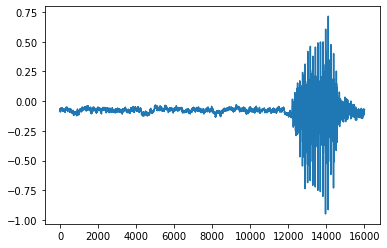

In [13]:
plt.plot(waveform.t().numpy());

torch.Size([1, 64, 81])


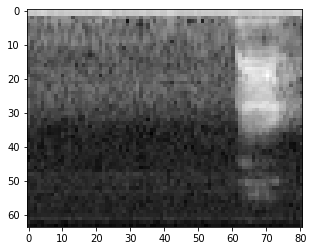

In [14]:
transform = torchaudio.transforms.MelSpectrogram(sample_rate=sample_rate, n_fft=400, win_length=None, hop_length=None, f_min=0.0, f_max=None, pad=0, n_mels=64, normalized=False)

transformed = transform(waveform)
print(transformed.shape)

plt.imshow(transformed.log2()[0,:,:].numpy(), cmap='gray');

# Data Loader

In the collate function, we also apply the resampling, and the text
encoding. The data loader uses the collate function to form the batches.


In [15]:
batch_size = 64

In [16]:
def pad_sequence(batch):
    
    # Move last to first
    dims = list(range(len(batch[0].shape)))
    dims.insert(0, dims.pop(-1))
    batch = [item.permute(*dims) for item in batch]
    
    # Make all tensor in a batch the same length by padding with zeros
    batch = torch.nn.utils.rnn.pad_sequence(batch, batch_first=True, padding_value=0.)
    
    # Move second to last
    dims = list(range(len(batch.shape)))
    dims.append(dims.pop(1))
    batch = batch.permute(*dims)

    return batch


def collate_fn(batch):

    # preprend tensor with blank character for RNN-T
    # prepend = char_blank
    prepend = ""
    # or pad in model

    # A data tuple has the form:
    # waveform, sample_rate, label, speaker_id, utterance_number

    tensors, targets_tensor, targets_original, tensors_length, targets_length = [], [], [], [], []

    # Gather in lists, and encode labels as indices
    for waveform, _, label, *_ in batch:
        
        waveform = transform(waveform)
        tensors += [waveform]
        tensors_length += torch.tensor([waveform.shape[-1]], dtype=torch.int)
        
        targets_tensor += [label_to_indices(prepend + label)]
        targets_original += [label]
        targets_length += torch.tensor([len(label)], dtype=torch.int)

    # Group the list of tensors into a batched tensor
    tensors = pad_sequence(tensors)
    targets_tensor = pad_sequence(targets_tensor)
    tensors_length = torch.stack(tensors_length)
    targets_length = torch.stack(targets_length)

    return tensors, targets_tensor, targets_original, tensors_length, targets_length


if device == "cuda":
    num_workers = 1
    pin_memory = True
else:
    num_workers = 0
    pin_memory = False

train_loader = torch.utils.data.DataLoader(
    train_set,
    batch_size=batch_size,
    shuffle=False,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory,
)

The CTC Setting
---------------

Suppose we have a model that takes an input spectrogram and returns a sequence of log-probabilities for each character at each time step.

In [17]:
class CTCModel(torch.nn.Module):
    def __init__(self, n_audio_features=transformed.shape[1], n_hidden=512, n_chars=len(chars)):
        super().__init__()
        self.rnn = torch.nn.RNN(input_size=n_audio_features, hidden_size=n_hidden//2, bidirectional=True)
        self.linear_first = torch.nn.Linear((n_hidden//2) * 2, n_hidden//4)
        self.linear_last = torch.nn.Linear(n_hidden//4, n_chars)
        
    def forward(self, x, y):
        # Apply model to x. Pass y.
        # Return both the output of the model and the target y.

        x = x.squeeze().permute(0, 2, 1)
        x, _ = self.rnn(x)
        x = self.linear_first(x)
        x = self.linear_last(x)
        return x, y


ctc_model = CTCModel()
# print([str(t.device) for t in ctc_model.parameters()])
ctc_model.to(device)
# print([str(t.device) for t in ctc_model.parameters()])
print(ctc_model)


def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


print(f"Number of parameters: {count_parameters(ctc_model):,}")

CTCModel(
  (rnn): RNN(64, 256, bidirectional=True)
  (linear_first): Linear(in_features=512, out_features=128, bias=True)
  (linear_last): Linear(in_features=128, out_features=27, bias=True)
)
Number of parameters: 234,011


In such a setup, we may run into an alignment issue between the input and the output sequences, where some sounds are longer than others, and so some characters might be repeated across many time steps. For instance, a possible alignment for the word `tree` is `ttr**eee*ee`. Indeed, starting with the alignment `ttr**eee*ee`, we first remove all the repeated characters to get `tr*e*e` and then remove the blank characters to get the word this corresponds to: `tree`. There are many such alignments for a given word, e.g. `ttr**eee*ee`, `trrrreee****e`, or `tre*e`. Note that `tree` is not an alignment of the word `tree` since the repeated `e` would collapse into a single `e`.

The CTC loss (Connectionist Temporal Classification, Graves et al., 2006) overcomes the alignment issue by summing over all alignments between the input and the output. More precisely, the CTC conditional probability marginalizes over the set of alignments that are no longer than the input sequence where it computes the probability for a single alignment step-by-step.

Here is an example showing how to use the CTC loss in PyTorch with a corresponding model. The loss function defined below takes as input a tensor of size
```
(batch size) x (input length) x (number of classes including blank)
```

In [18]:
def ctc_criterion(outputs, targets, output_lengths, target_lengths):
        """
        Apply the log softmax, and the CTC loss.

        Input:
        outputs: tensor of size (batch size, input length, number of classes including blank) containing output from network
        targets: tensor of size (batch size, max target length) containing the targets with zero padded
        output_lengths: tensor of size (batch size) containing the length of each output sequence
        target_lengths: tensor of size (batch size) containing the length of each target
        """
        
        # Apply log_softmax as part of criterion as done for rnnt_loss
        outputs = nn.functional.log_softmax(outputs, dim=-1)

        # Transpose into format consumed by PyTorch
        outputs = outputs.permute(1, 0, 2)

        # CTC
        # outputs: input length, batch size, number of classes (including blank)
        # targets: batch size, max target length
        # input_lengths: batch size
        # target_lengths: batch size
        return torch.nn.functional.ctc_loss(
            outputs,
            targets,
            output_lengths,
            target_lengths,
            blank=0,
            reduction='mean',
            zero_infinity=False
        )

Let's compute the error with an untrained model.

In [19]:
data, target, _, data_length, target_length = next(iter(train_loader))

print(data.shape, target.shape, data_length.shape, target_length.shape)

data = data.to(device)
target = target.to(device)

data, target = ctc_model(data, target)

loss = ctc_criterion(
    data,
    target,
    data_length,
    target_length,
)

# This number will be large given that we have not trained the model :)
print(loss.item())

torch.Size([64, 1, 64, 81]) torch.Size([64, 8]) torch.Size([64]) torch.Size([64])
27.63673210144043


And let's see what word the model assigns to the data point.

In [20]:
# Replace by https://gist.github.com/awni/56369a90d03953e370f3964c826ed4b0

def ctc_decode(tensor):
    # greedy decoder for CTC

    # find most likely label index for each element in the batch
    tensor = tensor.argmax(dim=-1)
    return torch.unique_consecutive(tensor, dim=-1)


target = indices_to_label(target[0])

indices = data[0, ...]
decoded = ctc_decode(indices)
word_recovered = indices_to_label(decoded)

# The result will be far from the target since we have not trained the model :)
print(target, "-->", decoded, "-->", word_recovered)

backward --> tensor([ 0,  6,  0,  6, 19,  6,  0,  6,  0,  2,  0, 15,  6,  0,  6,  0, 17,  3,
         8,  3,  5,  3, 11,  5, 23, 17,  6, 17,  6,  0,  6,  0]) --> ffsffboffqchceckewqfqff


The RNN Transducer Setting
--------------------------

As mentioned before, the CTC loss defines a distribution over all alignments with all output sequences no longer than the input sequence. However, as well as precluding tasks (e.g. text-to-speech) where the output sequence is longer than the input sequence, CTC does not model the interdependencies between the outputs.

The RNN Transducer loss (`Graves 2012 <https://arxiv.org/pdf/1211.3711.pdf>`__) extends the CTC loss by defining a distribution over output sequences of all lengths, and by jointly modelling both input-output and output-output dependencies.

To do this, an RNN Transducer model combines a transcription model taking the input spectrogram (as done for the CTC case) and a prediction model taking the target sequence. The prediction network attempts to model each element of the target sequence given the previous ones, starting with a blank prediction. 

In [21]:
class RNNTBlock(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size, bidirectional):
        super().__init__()
        self.rnn = torch.nn.GRU(input_size=input_size, hidden_size=hidden_size, bidirectional=bidirectional)
        if bidirectional:
          hidden_size *= 2
        self.linear = torch.nn.Linear(hidden_size, output_size)

    def forward(self, x, hidden=None):
        x, hidden = self.rnn(x, hidden)
        x = self.linear(x)
        return x, hidden

class RNNTModel(torch.nn.Module):
    # https://arxiv.org/pdf/1211.3711.pdf
    # https://github.com/HawkAaron/RNN-Transducer/blob/graves2013/model2012.py
    # https://github.com/lorenlugosch/transducer-tutorial/blob/main/transducer_tutorial_example.ipynb
    # https://arxiv.org/pdf/1811.06621.pdf

    def __init__(self, n_audio_features=transformed.shape[1], n_chars=len(chars)):
        super().__init__()

        hidden_size = 2048
        self.transcription_model = RNNTBlock(n_audio_features, hidden_size, n_chars, bidirectional=True)
        self.prediction_model = RNNTBlock(1, hidden_size, n_chars, bidirectional=False)

    def forward(self, x, y):
        # Apply model to x. Preprend blank character to y.
        # Return both the output of the model and the target y.

        x = x.squeeze().permute(0, 2, 1)
        x, _ = self.transcription_model(x)
        
        # print("first", y.shape)
        # y_pad = y.clone()
        # y = y_pad = torch.nn.functional.pad(y, (1,0,0,0), mode='constant', value=0)
        # print("second", y.shape)
        
        y = y.unsqueeze(-1).to(torch.float32)
        # print("third", y.shape)
        y, _ = self.prediction_model(y)
        # print("fourth", y.shape)

        x = x.unsqueeze(2)
        y = y.unsqueeze(1)

        # Fewer exponential by doing exp(x)*exp(y) instead of exp(x+y)
        # x = torch.exp(x)
        # y = torch.exp(y)
        # out = x * y
        # out = torch.nn.functional.log_softmax(x + y, dim=-1)
        # NOTE log_softmax done as part of loss

        return x + y # , y_pad

        # blank as last token hardcoded? (or more efficient)
        # emdedding layer to transcription?

        # too simple, try:
        # activation(x + y)
        # linear
        # (fused in loss) log_softmax

        # 9 million is too small --> 37 million worked okay --> 80 million
        # 100k samples at least would be better


rnnt_model = RNNTModel().to(device)
print(rnnt_model)
print(f"Number of parameters: {count_parameters(rnnt_model):,}")

RNNTModel(
  (transcription_model): RNNTBlock(
    (rnn): GRU(64, 2048, bidirectional=True)
    (linear): Linear(in_features=4096, out_features=27, bias=True)
  )
  (prediction_model): RNNTBlock(
    (rnn): GRU(1, 2048)
    (linear): Linear(in_features=2048, out_features=27, bias=True)
  )
)
Number of parameters: 38,744,118


Here is an example showing how to use the RNN Transducer loss in PyTorch with a corresponding model. The loss function defined below takes as input a tensor of size
```
(batch size) x (input length) x (target length) x (number of classes including blank)
```
Note the difference in expected shape when compared to the previous case with CTC. The tensor given to the RNN-T loss also carries information about what has been outputed.

In [22]:
def rnnt_criterion(outputs, targets, output_lengths, target_lengths):
    """
    Apply the log softmax, and the RNN-T loss.

    Input:
    outputs: tensor of size (batch size, input length, output length, number of classes including blank) containing output from network
    targets: tensor of size (batch size, max target length) containing the targets with zero padded
    output_lengths: tensor of size (batch size) containing the length of each output sequence
    target_lengths: tensor of size (batch size) containing the length of each target
    """

    # acts: Tensor of (batch x seqLength x labelLength x outputDim) containing output from network
    # labels: 2 dimensional Tensor containing all the targets of the batch with zero padded
    # act_lens: Tensor of size (batch) containing size of each output sequence from the network
    # label_lens: Tensor of (batch) containing label length of each example
    return rnnt_loss(outputs, targets, output_lengths, target_lengths)

Let's compute the error with an untrained model.

In [23]:
data, target, _, data_length, target_length = next(iter(train_loader))
print(data.shape, target.shape, data_length.shape, target_length.shape)

data = data.to(device)
target = target.to(device)

# start with zero
target = torch.nn.functional.pad(target, (1,0,0,0), mode='constant', value=0)
print("target shape", target.shape)
data = rnnt_model(data, target)
print("output", data.shape, target.shape, data_length.shape, target_length.shape)

loss = rnnt_criterion(
    data,
    target,
    data_length,
    target_length,
)

# This number will be large given that we have not trained the model :)
print(loss.item())

torch.Size([64, 1, 64, 81]) torch.Size([64, 8]) torch.Size([64]) torch.Size([64])
target shape torch.Size([64, 9])
output torch.Size([64, 81, 9, 27]) torch.Size([64, 9]) torch.Size([64]) torch.Size([64])
276.99346923828125


In [24]:
data, target, _, data_length, target_length = next(iter(train_loader))
print(data.shape, target.shape, data_length.shape, target_length.shape)

data = data.to(device)

data = data.squeeze().permute(0, 2, 1)
data, _ = rnnt_model.transcription_model(data)
print(data.shape)

print("target", target.shape)
target = target.to(device)
target = torch.nn.functional.pad(target, (1,0,0,0), mode='constant', value=0)
print("target", target.shape)
target = target.unsqueeze(-1).to(torch.float32)
print("target", target.shape)
target, _ = rnnt_model.prediction_model(target)
print(target.shape)

torch.Size([64, 1, 64, 81]) torch.Size([64, 8]) torch.Size([64]) torch.Size([64])
torch.Size([64, 81, 27])
target torch.Size([64, 8])
target torch.Size([64, 9])
target torch.Size([64, 9, 1])
torch.Size([64, 9, 27])


And let's see what word the model assigns to the data point.

In [25]:
def log_sum_exp(a, b):
    """
    Stable log sum exp.
    """
    return max(a, b) + math.log1p(math.exp(-abs(a-b)))

# STATIC RNNT DECODER
def rnnt_decode(log_probs, beam_size=1000, blank=0):
    """
    Decode best prefix in the RNN Transducer. This decoder is static, it does
    not update the next step distribution based on the previous prediction. As
    such it looks for hypotheses which are length U.

    https://github.com/awni/transducer/blob/master/decoders.py
    """
    T, U, V = log_probs.shape
    beam = [((), 0)];
    for i in range(T + U - 2):
        new_beam = {}
        for hyp, score in beam:
            u = len(hyp)
            t = i - u
            for v in range(V):
                if v == blank:
                    if t < T - 1:
                        new_hyp = hyp
                        new_score = score + log_probs[t, u, v]
                elif u < U - 1:
                    new_hyp = hyp + (v,)
                    new_score = score + log_probs[t, u, v]
                else:
                    continue

                old_score = new_beam.get(new_hyp, None)
                if old_score is not None:
                    new_beam[new_hyp] = log_sum_exp(old_score, new_score)
                else:
                    new_beam[new_hyp] = new_score

        new_beam = sorted(new_beam.items(), key=lambda x: x[1], reverse=True)
        beam = new_beam[:beam_size]

    hyp, score = beam[0]
    # best_score = score + log_probs[-1, -1, blank]
    return hyp


word = indices_to_label(target[0])

indices = data[0, ...]
decoded = rnnt_decode(indices)
word_recovered = indices_to_label(decoded)

# The result will be far from the target since we have not trained the model :)
print(word, "-->", decoded, "-->", word_recovered)

TypeError: ignored

In [30]:
indices_to_label(target[0])

TypeError: ignored

# Training

We will use the same optimization technique used in the paper, an Adam
optimizer with weight decay set to 0.0001. At first, we will train with
a learning rate of 0.01, but we will use a ``scheduler`` to decrease it
to 0.001 during training after 20 epochs.




In [ ]:
# model, criterion = ctc_model, ctc_criterion
model, criterion = rnnt_model, rnnt_criterion

In [ ]:
# optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=0.0001)

"""
optim.Adadelta(
    model.parameters(),
    lr=0.6,
    weight_decay=1e-5,
    eps=1e-8,
    rho=0.95,
)
"""

# https://github.com/silversparro/wav2letter.pytorch/blob/master/train.py
optimizer = optim.SGD(
    model.parameters(),
    # lr=0.6,
    # lr=0.3,
    # lr=0.1,
    lr=0.0001,
    # lr=1e-5,
    # weight_decay=1e-5,
    momentum=0.90,
    nesterov=True,
)

# scheduler = optim.lr_scheduler.ExponentialLR(optimizer, 0.995)
# scheduler = optim.lr_scheduler.CyclicLR(optimizer, base_lr=.06, max_lr=.6, step_size_up=100)
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20*300, gamma=0.1)  # reduce the learning after 20 epochs by a factor of 10
# scheduler = torch.optim.swa_utils.SWALR(optimizer, anneal_strategy="linear", anneal_epochs=5, swa_lr=0.05)
# scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50)

Now let’s define a training function that will feed our training data
into the model and perform the backward pass and optimization steps. For
training, the loss we will use is the negative log-likelihood. The
network will then be tested after each epoch to see how the accuracy
varies during the training.




In [ ]:
negative_batches = []
def train(model, epoch, log_interval):
    model.train()
    # for batch_idx, (data, target, _, data_length, target_length) in enumerate(train_loader):
    while True:
        batch_idx, (data, target, _, data_length, target_length) = next(iter(enumerate(train_loader)))

        data = data.to(device)
        target = target.to(device)

        target = torch.nn.functional.pad(target, (1,0,0,0), mode='constant', value=0)
        data = model(data, target)

        loss = criterion(
            data,
            target,
            data_length,
            target_length,
        )
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        lrs.append(optimizer.param_groups[0]["lr"])
        
        # https://stackoverflow.com/questions/53405934/how-to-print-the-actual-learning-rate-in-adadelta-in-pytorch
        # acc_deltas = [optimizer.state[i]["acc_delta"] for i in optimizer.state.keys() if "acc_delta" in optimizer.state[i].keys()]
        # print(acc_deltas)
        
        # scheduler.step()

        # print training stats
        if batch_idx % log_interval == 0:
            print(f"Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}")

        # update progress bar
        pbar.update(pbar_update)
        # record loss
        losses.append(loss.item())

        if loss < 0:
          print(batch_idx)
          negative_batches.append(batch_idx)

Now that we have a training function, we need to make one for testing
the networks accuracy. We will set the model to ``eval()`` mode and then
run inference on the test dataset. Calling ``eval()`` sets the training
variable in all modules in the network to false. Certain layers like
batch normalization and dropout layers behave differently during
training so this step is crucial for getting correct results.




Finally, we can train and test the network. We will train the network
for ten epochs then reduce the learn rate and train for ten more epochs.
The network will be tested after each epoch to see how the accuracy
varies during the training.




In [ ]:
log_interval = 20
n_epoch = 100

pbar_update = 1 / len(train_loader)
losses, lrs = [], []

torch.autograd.set_detect_anomaly(False)                                                                                                                                

# The transform needs to live on the same device as the model and the data.
# transform = transform.to(device)
with tqdm(total=n_epoch) as pbar:
    for epoch in range(1, n_epoch + 1):
        train(model, epoch, log_interval)
        # scheduler.step()

In [ ]:
# Let's plot the training loss versus the number of iteration.
plt.plot(losses)
plt.yscale("log")
plt.title("training loss");

In [ ]:
# Let's plot the training loss versus the number of iteration.
plt.plot(lrs)
plt.title("learning rate");

Conclusion
----------

In this tutorial, we have used torchaudio to compare the CTC and the RNN Transducer losses with simple models to compare them.

# WIP

In [ ]:
# ZT RNNT DECODER, EXPERIMENT


def model_encoder(x):
    x = x.squeeze().permute(0, 2, 1)
    x, _ = rnnt_model.transcription_model(x)
    x = x.unsqueeze(2)
    # Fewer exponential by doing it on x and y instead of x + y
    # x = torch.exp(x)
    return x
  

def model_decoder(y, hidden=None):
    # y = torch.nn.functional.pad(y, (1,0,0,0), mode='constant', value=0)
        
    y = y.unsqueeze(-1).to(torch.float32)
    
    if hidden is None:
        y, hidden = rnnt_model.prediction_model(y)
    else:
        y, hidden = rnnt_model.prediction_model(y, hidden)

    y = y.unsqueeze(1)

    # Fewer exponential by doing it on x and y instead of x + y
    # y = torch.exp(y)

    return y, hidden


def model_joint(x, y):
    return x + y


# def rnnt_decode_zt(model, inputs, input_lengths):
def rnnt_decode_zt(inputs):
    # https://github.com/ZhengkunTian/rnn-transducer/blob/master/rnnt/search.py

    # assert inputs.dim() == 3
    # f = [batch_size, time_step, feature_dim]
    # f, _ = model.encoder(inputs, input_lengths)
    # print("begin", inputs.shape)
    f = model_encoder(inputs)

    zero_token = torch.LongTensor([[0]], device=inputs.device)
    # print("zero_token shape", zero_token.shape)

    results = []
    batch_size = inputs.size(0)

    # def decode(inputs, inputs):
    def decode(inputs):
        lengths = len(inputs)

        log_prob = 0
        token_list = []
        gu, hidden = model_decoder(zero_token)
        # print("start gu shape", gu.shape)
        
        for t in range(lengths):
            # print("begin loop", inputs[t].shape, gu[0].shape)
            h = model_joint(inputs[t], gu)
            # print("after model_joint", h.shape)
            # h = model_joint(inputs[t].view(-1), gu.view(-1))
            # out = F.log_softmax(h, dim=0)
            out = F.log_softmax(h, dim=-1)
            # print(out.shape)
            prob, pred = torch.max(out, dim=-1)
            # print(prob.shape, pred.shape)
            pred = int(pred.item())
            log_prob += prob.item()
            if pred != 0:
                token_list.append(pred)
                token = torch.LongTensor([[pred]])
                if zero_token.is_cuda:
                    token = token.cuda()
                gu, hidden = model_decoder(token, hidden=hidden)

        return token_list

    for i in range(batch_size):
        # decoded_seq = decode(f[i], input_lengths[i])
        decoded_seq = decode(f[i])
        results.append(decoded_seq)

    return results


inputs, outputs, words, input_length, output_length = next(iter(train_loader))

# word = indices_to_label(outputs[0])
# indices = data[0, ...].unsqueeze(0)

# print("inputs shape", inputs.shape)
decoded = rnnt_decode_zt(inputs)
word_recovered = [indices_to_label(d) for d in decoded]

# The result will be far from the target since we have not trained the model :)
print(words[0], "-->", decoded[0], "-->", word_recovered[0])

In [ ]:
"""
# GREEDY RNN-T DECODER, WIP
import math


def rnnt_decode(data):
    # Experimental greedy RNN-T decoder

    i, j = 0, 0
    output = []

    top, ind = torch.max(data[:,i,j,:], dim=-1)
    output.append(ind)

    done = False
    while not done:
        if i+1 < data.shape[1]:
            top_i, ind_i = torch.max(data[:,i+1,j,:], dim=-1)
        else:
            top_i = - math.inf
        if j+1 < data.shape[2]:
            top_j, ind_j = torch.max(data[:,i,j+1,:], dim=-1)
        else:
            top_j = - math.inf
    
        if top_i < -1 and top_j < -1:
            break
    
        if top_i < top_j:
            output.append(ind_j)
            j += 1
        else:
            output.append(ind_i)
            i += 1
    return torch.cat(output)


decoded = rnnt_decode(data)
word_recovered = indices_to_label(decoded)

# The result will be far from the target since we have not trained the model :)
print(f'"{target}" -->\n{decoded}\n--> "{word_recovered}"')
""";